<a href="https://colab.research.google.com/github/Tanya160204/Tanya160204/blob/main/stock_price_prediction_with_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing dependencies

In [1]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow


Load Stock details

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the stock symbol and the date range
symbol = 'TSLA'
start_date = '2010-01-01'
end_date = '2023-11-01'

# Download the stock data using Yahoo Finance
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Show the first few rows of the dataset
stock_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29 00:00:00+00:00,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30 00:00:00+00:00,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01 00:00:00+00:00,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02 00:00:00+00:00,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06 00:00:00+00:00,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


Preprocessing

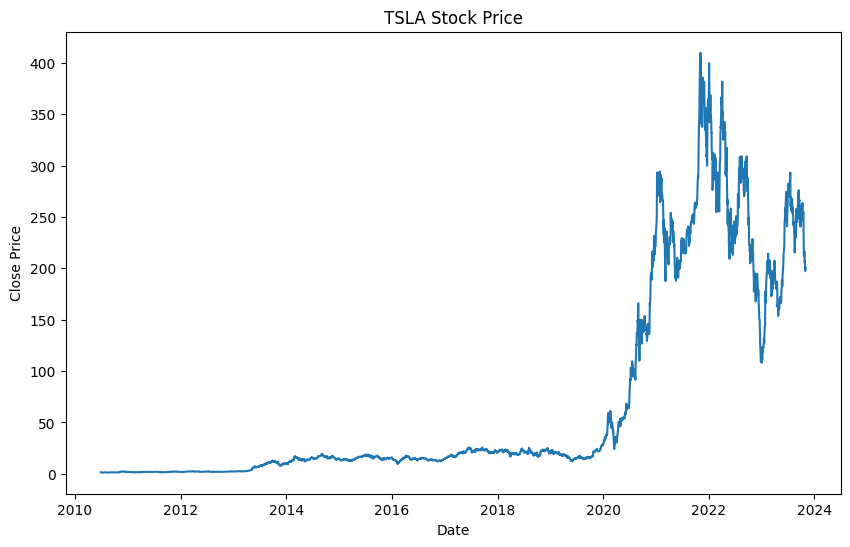

In [3]:
# Use 'Close' price for prediction
data = stock_data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Plot the close price
plt.figure(figsize=(10,6))
plt.plot(data['Close'])
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


Create Training and Test Sets

In [4]:
# Define the size of the training set
train_size = int(len(scaled_data) * 0.8)

# Create training and test datasets
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the training dataset with past 60 days' data (for LSTM)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # Past 60 days
        y.append(data[i, 0])  # Next day's price
    return np.array(X), np.array(y)

# Create training and test datasets
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape X_train and X_test for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, X_test.shape)


(2627, 60, 1) (612, 60, 1)


Build and Train the LSTM Model

In [5]:
# Build the LSTM model
model = Sequential()

# Add the first LSTM layer with Dropout for regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5017e-04 - val_loss: 0.0032
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6037e-04 - val_loss: 0.0045
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5280e-04 - val_loss: 0.0034
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3326e-04 - val_loss: 0.0042
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4481e-04 - val_loss: 0.0039
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2771e-04 - val_loss: 0.0021
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6399e-04 - val_loss: 0.0021
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5096e-04 - val_loss: 0.0019
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.1996e-04 - val_loss: 0.0038


Make Predictions and Plot Results

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


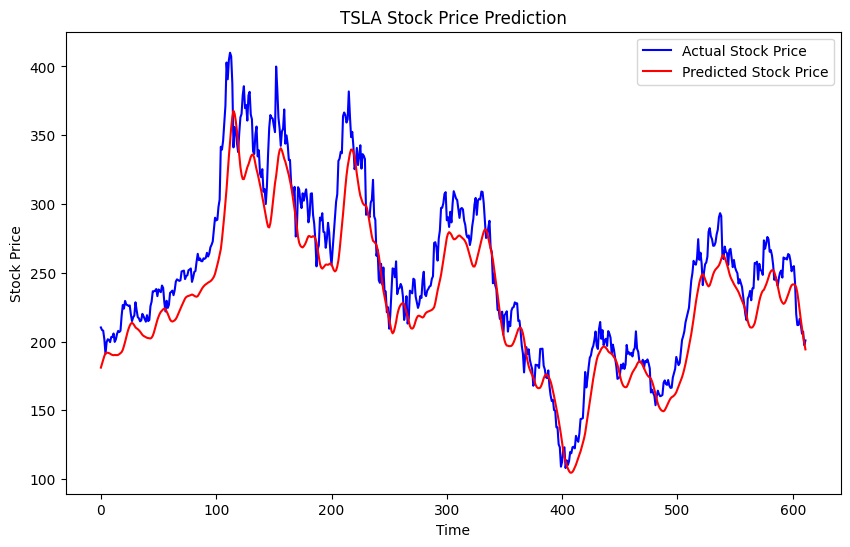

In [6]:
# Make predictions on the test set
predicted_stock_price = model.predict(X_test)

# Inverse the scaling to get actual stock prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title(f'{symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Evaluate the Model


In [7]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_stock_price))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 25.2745256223516
